In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt','r').read().splitlines()
len(words)

32033

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in  enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
#build dataset
block_size = 3

def build_dataset(words):
    X,y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    y = torch.tensor(y)    
    return X,y


n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_tr,y_tr = build_dataset(words[:n1])
X_dev,y_dev = build_dataset(words[n1:n2])    
X_te , y_te = build_dataset(words[n2:])

In [6]:
X_tr[1]

tensor([ 0,  0, 25])

In [7]:
for x,y in zip(X_tr[:5],y_tr[:5]):
    print(''.join(itos[ix.item()] for ix in x),'---->',itos[y.item()])

... ----> y
..y ----> u
.yu ----> h
yuh ----> e
uhe ----> n


In [21]:
class Linear:
    def __init__(self,fan_in,fan_out,bias = True):
        self.weight = torch.randn(fan_in,fan_out) /fan_in **0.5 #initalizing weight
        self.bias = torch.randn(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else[self.bias])
    
class BatchNorm:
    def __init__(self,dim,eps = 1e-5,momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        """
        if True mean and variance are computed from the current batch.
        Instead of using batch statistics, it uses the running mean and variance
        collected during training.
        """
        self.Training = True 
    #backward
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
    # training with running 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self,x):
        if self.Training:
            x_mean = x.mean(0,keepdim=True)
            x_var = x.var(0,keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        #Normalize
        xhat = (x-x_mean)/torch.sqrt(x_var + self.eps)
        self.out =  self.gamma * xhat + self.beta
        #update buffer
        if self.Training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        return self.out
    
    def parameters(self):
        return[self.gamma,self.beta]
                

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
            

class Embedding:
    def __init__(self,num_embedding,embedding_dim):
        self.weight = torch.randn((num_embedding,embedding_dim))
    def __call__(self,x):
        self.out = self.weight[x]
        return self.out
    def parameters(self):
        return[self.weight]
    
class Flatten:
    def __call__(self,x):
        self.out = x.view(x.shape[0],-1)
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self,layers):
        self.layers = layers
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [9]:
torch.manual_seed(42)

In [22]:
n_emb = 10  # the dim of chas embedding vectors
n_hidden = 200 # num of neurons in hidden layer of the MLP
model = Sequential([
    Embedding(vocab_size,n_emb),
    Flatten(),
    Linear(n_emb*block_size,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size)
])

with torch.no_grad():
    layers[-1].weight += 0.1 #last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total Parameters
for p in parameters:
    p.requires_grad = True

12097


In [23]:
epochs = 200000
batch_size = 64
lossi = []

for i in range(epochs):
    #create mini batch
    ix = torch.randint(0, X_tr.shape[0], (batch_size,))
    Xb,yb = X_tr[ix],y_tr[ix] #batch 
    #forwad pass
    logits = model(Xb)
    loss = F.cross_entropy(logits,yb)
    
    #backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i<15000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 1000 ==0 :
        print(f"{i:7d}/{epochs:7d}:{loss.item():4f}")
    lossi.append(loss.log10().item())
   

      0/ 200000:3.816212
   1000/ 200000:2.436237
   2000/ 200000:2.459527
   3000/ 200000:2.244724
   4000/ 200000:2.096338
   5000/ 200000:2.291623
   6000/ 200000:2.251402
   7000/ 200000:2.087428
   8000/ 200000:2.149114
   9000/ 200000:2.207032
  10000/ 200000:2.361435
  11000/ 200000:2.147051
  12000/ 200000:2.189817
  13000/ 200000:2.179396
  14000/ 200000:2.186771
  15000/ 200000:2.222023
  16000/ 200000:2.297998
  17000/ 200000:2.032361
  18000/ 200000:2.191801
  19000/ 200000:1.948480
  20000/ 200000:1.952637
  21000/ 200000:2.317223
  22000/ 200000:2.101657
  23000/ 200000:1.869275
  24000/ 200000:2.044770
  25000/ 200000:2.199614
  26000/ 200000:2.252892
  27000/ 200000:2.190793
  28000/ 200000:2.437472
  29000/ 200000:2.428718
  30000/ 200000:2.420080
  31000/ 200000:2.178161
  32000/ 200000:2.061903
  33000/ 200000:2.111524
  34000/ 200000:2.003339
  35000/ 200000:1.800871
  36000/ 200000:2.155500
  37000/ 200000:2.314215
  38000/ 200000:2.310822
  39000/ 200000:2.013570


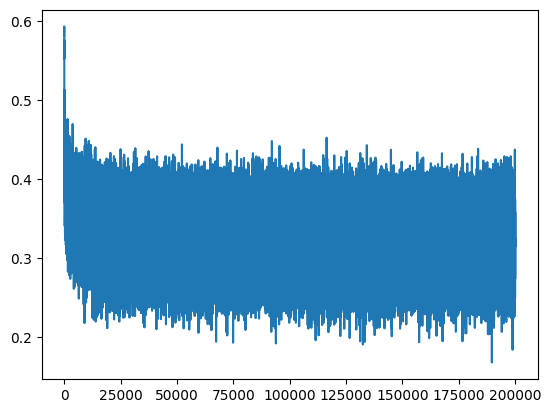

In [24]:
plt.plot(lossi)

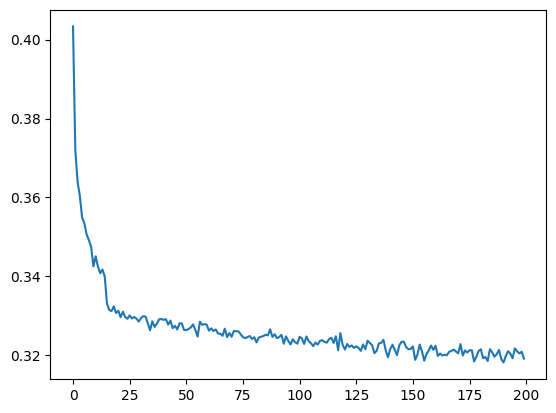

In [25]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [26]:
torch.tensor(lossi).view(-1,1000).mean(1).shape

torch.Size([200])

In [27]:
# put layers into eval mode
for layer in model.layers:
    layer.Training = False

In [28]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(X_tr,y_tr),
        'val':(X_dev,y_dev),
        'test':(X_te,y_te),
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item()) 
    
split_loss('train')       
split_loss('val')       

train 2.0748403072357178
val 2.1163761615753174


In [29]:
#sample from model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits,dim = 1)
        #sample from the distribution
        ix = torch.multinomial(probs,num_samples=1).item()
        #shift the conetxt window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

fro.
leces.
najanson.
maraim.
joan.
amileigh.
pael.
orlisamiah.
beckydeniyah.
cris.
jamoni.
kord.
jouri.
lousaylian.
hada.
absreee.
meyah.
neo.
savrabiwaan.
lain.
